<a href="https://colab.research.google.com/github/shreyafz/Plant-Disease-Classifier/blob/main/plant_disease_classifcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to CV

In [ ]:
!pip install -q tensorflow_datasets

In [ ]:
import tensorflow as tf  # Import the core TensorFlow library

from tensorflow import keras  # Import the high-level Keras API for building neural networks

from tensorflow.keras import layers  # Import the layers (building blocks) for neural networks

from tensorflow.keras.models import Sequential  # Import the Sequential model class for linear stacking of layers

import tensorflow_datasets as tfds  # Import TensorFlow Datasets for loading datasets

import matplotlib.pyplot as plt  # Import Matplotlib for visualization (plotting)

from tensorflow.keras.applications import EfficientNetB0, VGG16  # Import pre-trained models for transfer learning

from tensorflow.keras.callbacks import EarlyStopping  # Import the EarlyStopping callback for training efficiency

import math  # Import the math module for mathematical functions (may be used for calculations)

import numpy as np  # Import NumPy for numerical computations (often used with TensorFlow)


# CNN building blocks

Convolutional neural networks, also known as CNNs, are a specific type of neural networks that are generally composed of the following layers:

![](https://stanford.edu/~shervine/teaching/cs-230/illustrations/architecture-cnn-en.jpeg?3b7fccd728e29dc619e1bd8022bf71cf)

source: [Convolutional Neural Networks cheatsheet](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks)

**Convolution layer (CONV):** The convolution layer (CONV) uses filters that perform convolution operations as it is scanning the input `I` with respect to its dimensions. Its hyperparameters include the filter size `F` and stride
`S`. The resulting output `O` is called feature map or activation map. We can use the following formula to compute the output size based on the input parameters. Note that you can have different strides horizontally and vertically.


$\begin{aligned} & \text { output width }=\frac{W-F_w+2 P}{S_w}+1 \\ & \text { output height }=\frac{H-F_h+2 P}{S_h}+1\end{aligned}$

![](https://stanford.edu/~shervine/teaching/cs-230/illustrations/convolution-layer-a.png?1c517e00cb8d709baf32fc3d39ebae67)


In [ ]:
IMG_SIZE = 180  # Define the target image size for resizing

# Download the image from the provided URL
image_url = "https://static.wixstatic.com/media/e6591e_3a5449fe774a4993a1166b1d33e233f7~mv2_d_1880_1253_s_2.jpg/v1/fill/w_1000,h_666,al_c,q_90,usm_0.66_1.00_0.01/e6591e_3a5449fe774a4993a1166b1d33e233f7~mv2_d_1880_1253_s_2.jpg"
image_path = tf.keras.utils.get_file("image_test", image_url)

# Load the image using Keras' image loading functionality
img = keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))

# Convert the loaded image to a NumPy array
img_array = tf.keras.preprocessing.image.img_to_array(img)

# Convert the NumPy array to a TensorFlow tensor
img_tensor = tf.convert_to_tensor(img_array)

# Add a batch dimension to the tensor (necessary for most machine learning models)
img_tensor = tf.expand_dims(img_tensor, 0)

# Print the minimum and maximum values in the image array (for informative purposes)
print(img_array.min(), img_array.max())

# Normalize the image pixel values to be between 0 and 1 (commonly used for image processing)
img_tensor = tf.divide(img_tensor, 255.0)


121362/121362 [==============================] - 0s 0us/step
0.0 255.0


In [ ]:
img_array.shape

(180, 180, 3)

In [ ]:
img_array[100,100, 2]

0.0

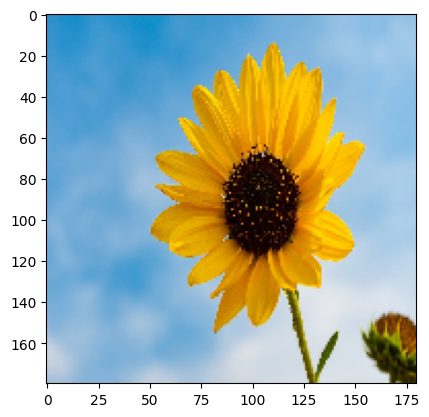

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
cnn_layer = layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3))
img_tensor_out = cnn_layer(img_tensor)

In [ ]:
img_tensor_out.shape

TensorShape([1, 180, 180, 16])

In [ ]:
def compute_conv_output_size(input_size, kernel_size, stride, padding):
    """
    Compute the output size of a single convolutional layer.

    Parameters:
        input_size (tuple): The input size of the data in the format (height, width, channels).
        kernel_size (int): The size of the convolutional kernel (assuming it's square).
        stride (int): The stride of the convolution.
        padding (int): The amount of zero-padding around the input.

    Returns:
        tuple: The output size of the convolutional layer in the format (height, width, channels).
    """
    output_size = list(input_size)

    output_size[0] = ((output_size[0] - kernel_size + 2 * padding) // stride) + 1
    output_size[1] = ((output_size[1] - kernel_size + 2 * padding) // stride) + 1

    return tuple(output_size)

In [ ]:
input_size = (IMG_SIZE, IMG_SIZE)
kernel_size = 3
stride = 1
padding = 1
compute_conv_output_size((IMG_SIZE, IMG_SIZE), 3, 1, 1)

(180, 180)

**Pooling (POOL):**The pooling layer (POOL) is a downsampling operation, typically applied after a convolution layer, which does some spatial invariance. In particular, max and average pooling are special kinds of pooling where the maximum and average value is taken, respectively.

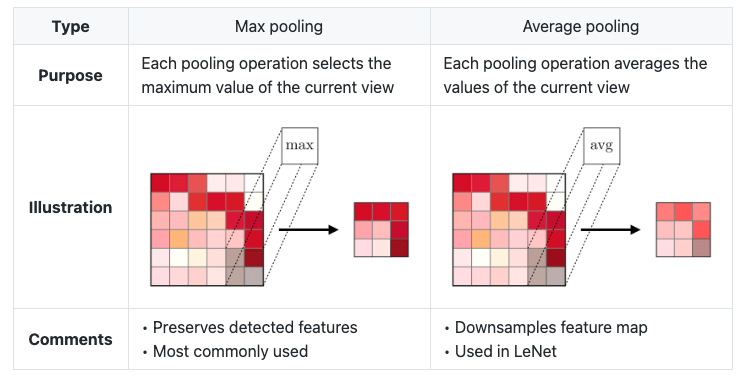

In [ ]:
max_pooling_layer = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))  # Define a MaxPooling2D layer with pool size 2x2 and stride 2
img_tensor_out = max_pooling_layer(img_tensor)  # Apply the MaxPooling2D layer to the input tensor
print(f"Output shape after MaxPooling2D: {img_tensor_out.shape}")  # Print the output shape (tensor dimensions)


Output shape after MaxPooling2D: (1, 90, 90, 3)


In [ ]:
def compute_maxpool_output_size(input_size, pool_size, stride):
    """
    Compute the output size of a Max Pooling layer in a Convolutional Neural Network (CNN).

    Parameters:
        input_size (tuple): The input size of the data in the format (height, width, channels).
        pool_size (int): The size of the pooling window in both height and width dimensions.
        stride (int): The stride length for the pooling operation in both height and width dimensions.

    Returns:
        tuple: The output size of the Max Pooling layer in the format (height, width, channels).
    """
    output_size = list(input_size)

    output_size[0] = ((output_size[0] - pool_size) // stride) + 1
    output_size[1] = ((output_size[1] - pool_size) // stride) + 1

    return tuple(output_size)

In [ ]:
input_size = (IMG_SIZE, IMG_SIZE, 3)  # Example input size: (height, width, channels)
pool_size = 2  # Example pooling window size (assuming it's square)
stride = 2  # Example stride length (assuming it's the same for both height and width)

output_size = compute_maxpool_output_size(input_size, pool_size, stride)
output_size

(90, 90, 3)

**Fully Connected (FC):**The fully connected layer (FC) operates on a flattened input where each input is connected to all neurons. If present, FC layers are usually found towards the end of CNN architectures and can be used to optimize objectives such as class scores.

![](https://stanford.edu/~shervine/teaching/cs-230/illustrations/fully-connected-ltr.png?32caf9e07c79d652faa292812579d063)

In [ ]:
flatten_layer = layers.Flatten()  # Define a Flatten layer to convert the 2D tensor to 1D
img_tensor_out = flatten_layer(img_tensor)  # Flatten the input tensor
dense_layer = layers.Dense(128, activation="relu")  # Define a Dense layer with 128 neurons and ReLU activation
img_tensor_out = dense_layer(img_tensor_out)  # Apply the Dense layer to the flattened output
print(f"Output shape after Dense layer: {img_tensor_out.shape}")  # Print the output shape


Output shape after Dense layer: (1, 128)


In [ ]:
def count_trainable_parameters(cnn_layers):
    """
    Count the number of trainable parameters in a Convolutional Neural Network (CNN).

    Parameters:
        cnn_layers (list): A list of tuples representing the CNN layers in the format:
                           [(layer_type, parameters), ...]
                           where layer_type is 'conv', 'pool', or 'dense',
                           and parameters is a tuple with the layer-specific details.

    Returns:
        int: The total number of trainable parameters in the CNN.
    """
    trainable_params = 0

    for layer_type, parameters in cnn_layers:
        if layer_type == 'conv':
            filters, kernel_size, _, _, _ = parameters
            in_channels, out_channels = filters
            trainable_params += (in_channels * out_channels * kernel_size * kernel_size) + out_channels

        elif layer_type == 'dense':
            units, _ = parameters
            trainable_params += units

    return trainable_params


# Example usage:
cnn_layers = [
    ('conv', ((3, 64), 3, 1, 1, 'relu')),  # Convolutional layer with 3 input channels, 64 output channels, 3x3 kernel
    ('conv', ((64, 128), 3, 1, 1, 'relu')), # Convolutional layer with 64 input channels, 128 output channels, 3x3 kernel
    ('dense', (256, 'relu')),              # Dense layer with 256 units
]

total_trainable_params = count_trainable_parameters(cnn_layers)
print("Total trainable parameters in the CNN:", total_trainable_params)

Total trainable parameters in the CNN: 75904


# Plant disease clasification

### Load dataset

In [ ]:
(ds_train, ds_test), ds_info = tfds.load('citrus_leaves', split=['train[:75%]', 'train[75%:]'], shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/594 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/citrus_leaves/0.1.2.incompleteH70I01/citrus_leaves-train.tfrecord*...:   0…

Dataset citrus_leaves downloaded and prepared to /root/tensorflow_datasets/citrus_leaves/0.1.2. Subsequent calls will reuse this data.


In [ ]:
ds_info.splits["train"].num_examples

594

In [ ]:
ds_train.cardinality().numpy()# Get the number of elements (cardinality) in the training dataset

446

In [ ]:
ds_test.cardinality().numpy()# Get the number of elements (cardinality) in the training dataset

148

In [ ]:
labels = ds_info.features["label"].names

In [ ]:
labels

['Black spot', 'canker', 'greening', 'healthy']

In [ ]:
x, y = next(ds_train.as_numpy_iterator())
x.shape


(256, 256, 3)

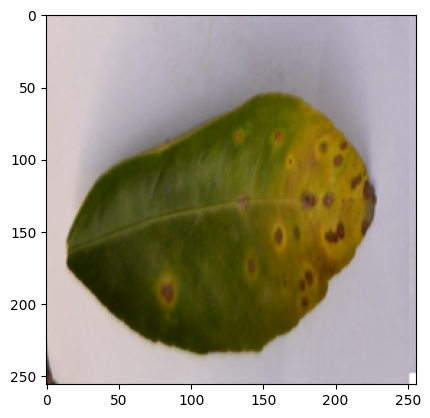

In [ ]:
plt.imshow(x)
plt.show()

In [ ]:
type(x)

numpy.ndarray

In [ ]:
x.ndim

3

In [ ]:
x.shape

(256, 256, 3)

In [ ]:
b = x[:,:, 0]
b.shape

(256, 256)

In [ ]:
g = x[:,:,1]

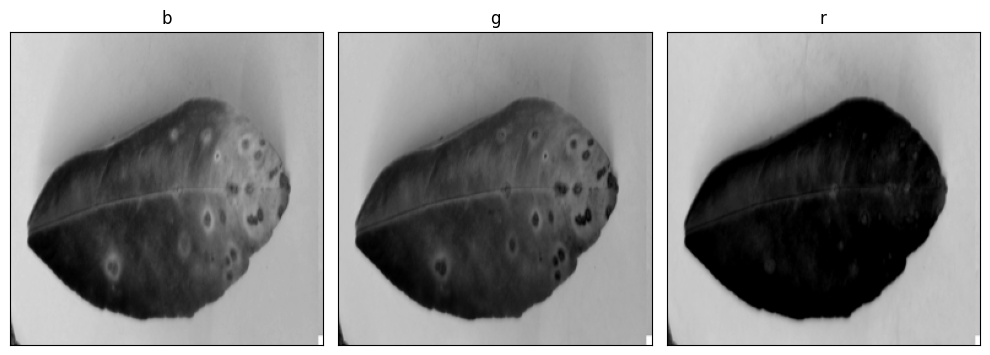

In [ ]:
fig = plt.figure(figsize=(10, 10))  # Create a figure with specified size (10x10)
ch_labels = ["b", "g", "r"]  # Define labels for the color channels (assuming RGB)

# Iterate through each color channel
for i in range(len(ch_labels)):
    ax = fig.add_subplot(1, 3, i + 1)  # Create a subplot at position (1 row, 3 columns, i+1th subplot)
    ax.imshow(x[:, :, i], cmap="gray")  # Display the i-th channel as grayscale
    ax.set_title(ch_labels[i])  # Set the title of the subplot to the corresponding channel label
    ax.set_xticks([])  # Remove x-axis ticks for cleaner visualization (optional)
    ax.set_yticks([])  # Remove y-axis ticks for cleaner visualization (optional)

plt.tight_layout()  # Adjust spacing between subplots for better readability (optional)
plt.show()  # Display the created figure


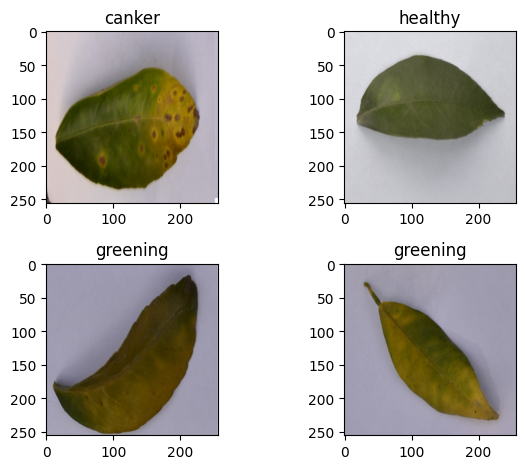

In [ ]:
fig = plt.figure()  # Create a figure object

# Take the first 4 elements (images and labels) from the training dataset
subset = ds_train.take(4)

# Iterate through the subset of data
for i, (image, label_idx) in enumerate(subset.as_numpy_iterator()):
    ax = fig.add_subplot(2, 2, i + 1)  # Create a subplot at position (i+1) in a 2x2 grid

    # Display the image
    ax.imshow(image)

    # Assuming `labels` is a list containing class names for each index
    ax.set_title(labels[label_idx])  # Set the title to the corresponding label

# Adjust spacing for better readability
plt.tight_layout()

# Display the created figure
plt.show()


In [ ]:
try:
  # Attempt to connect to a TPU runtime
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
  print("Device:", tpu.master())  # Print TPU master address if connected
  strategy = tf.distribute.TPUStrategy(tpu)  # Create TPUStrategy for TPU training
except ValueError:
  print("Not connected to a TPU runtime. Using CPU/GPU strategy")
  strategy = tf.distribute.MirroredStrategy()  # Use MirroredStrategy for CPU/GPU training


Not connected to a TPU runtime. Using CPU/GPU strategy


In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 32
NUM_CLASSES = len(labels)
IMG_SHAPE = (IMG_SIZE, IMG_SIZE)

In [ ]:
def process_image(image, label):
  """
  This function preprocesses an image and its corresponding label for training.

  Args:
      image: A TensorFlow tensor representing the image data.
      label: An integer representing the image's class label.

  Returns:
      A tuple containing the preprocessed image (float32 tensor) and one-hot encoded label.
  """

  # Resize the image to the target size (IMG_SHAPE)
  image = tf.image.resize(image, IMG_SHAPE)

  # Cast the image data type to float32 (for calculations)
  image = tf.cast(image, tf.float32)

  # Normalize the image pixel values between 0 and 1
  image = image / 255.0

  # One-hot encode the label (convert integer label to a vector)
  label = tf.one_hot(label, NUM_CLASSES)

  # Return the preprocessed image and label
  return image, label

In [ ]:
ds_train = ds_train.map(lambda img, label: process_image(img, label))
ds_test = ds_test.map(process_image)

In [ ]:
for img, label in ds_train.take(3):
    print(img.shape,label.shape, img.dtype) # check image andlabel tensor shapes

(256, 256, 3) (4,) <dtype: 'float32'>
(256, 256, 3) (4,) <dtype: 'float32'>
(256, 256, 3) (4,) <dtype: 'float32'>


In [ ]:
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

## Using Transfer Learning

In [ ]:
img_augmentation = Sequential([
  # Randomly rotate images up to 15 degrees
  layers.RandomRotation(factor=0.15),

  # Randomly translate images up to 10% horizontally and vertically
  layers.RandomTranslation(height_factor=0.1, width_factor=0.1),

  # Randomly flip images horizontally
  layers.RandomFlip(),

  # Randomly adjust image contrast up to 10%
  layers.RandomContrast(factor=0.1)
], name="img_augmentation")

In [ ]:
def plot_hist(hist):
  """Plots training and validation loss/accuracy curves from the training history.

  Args:
      hist: A dictionary containing the training history (e.g., from model.fit).
  """

  fig = plt.figure(figsize=(10, 5))  # Create a figure with specified size

  # Subplot for loss
  ax = fig.add_subplot(121)  # Add a subplot at position (1, 2, 1) in a 1x2 grid
  ax.plot(hist.history["loss"])  # Plot training loss
  ax.plot(hist.history["val_loss"])  # Plot validation loss
  ax.set_title("Model Loss")  # Set subplot title
  ax.set_ylabel("Loss")  # Set y-axis label
  ax.set_xlabel("Epoch")  # Set x-axis label
  ax.legend(["Train", "Validation"], loc="upper left")  # Add legend

  # Subplot for accuracy
  ax = fig.add_subplot(122)  # Add a subplot at position (1, 2, 2)
  ax.plot(hist.history["accuracy"])  # Plot training accuracy
  ax.plot(hist.history["val_accuracy"])  # Plot validation accuracy
  ax.set_title("Model Accuracy")  # Set subplot title
  ax.set_ylabel("Accuracy")  # Set y-axis label
  ax.set_xlabel("Epoch")  # Set x-axis label
  ax.legend(["Train", "Validation"], loc="upper left")  # Add legend

  plt.tight_layout()  # Adjust spacing for better readability (optional)
  plt.show()  # Display the created figure


def build_from_scratch_model():
  """Builds a CNN model from scratch.

  Returns:
      A compiled Keras model.
  """

  model = Sequential([
      # Convolutional layers with ReLU activation and padding
      layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),

      # Dropout layer for regularization
      layers.Dropout(0.2),

      # Flatten layer to convert 2D to 1D for dense layers
      layers.Flatten(),

      # Dense layers with ReLU activation
      layers.Dense(128, activation='relu'),

      # Output layer with softmax activation for multi-class classification
      layers.Dense(NUM_CLASSES, activation="softmax")
  ])

  # Set optimizer and compile the model
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
  model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
  return model


def build_model_non_pretrained_weights():
  """Builds a model using EfficientNetB0 without pre-trained weights.

  Returns:
      A compiled Keras model.
  """

  # Define the input layer
  inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

  # Build the EfficientNetB0 model without pre-trained weights
  #  - include_top=True: Include the top classification layers
  #  - input_tensor=inputs: Specify the input tensor
  #  - weights=None: Don't load pre-trained weights
  #  - classes=NUM_CLASSES: Set the number of output classes
  outputs = EfficientNetB0(include_top=True, input_tensor=inputs, weights=None, classes=NUM_CLASSES)(inputs)

  # Create a Keras Model object from the inputs and outputs
  model = tf.keras.Model(inputs, outputs)

  # Compile the model with optimizer, loss function, and metrics
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

  return model



def build_model_with_pretrained_weights_efficientNet():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    inputs = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")
    model.trainable = False # Freeze the pretrained weights
    outputs = layers.Flatten()(model.output)# Rebuild top
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(outputs)
    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


def build_model_with_pretrained_weights_vgg16():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    inputs = img_augmentation(inputs)
    model = VGG16(include_top=False, input_tensor=inputs, weights="imagenet")
    model.trainable = False # Freeze the pretrained weights

    # Rebuild top
    outputs = model.output
    outputs = layers.GlobalAveragePooling2D(name="avg_pool")(outputs)
    outputs = layers.BatchNormalization()(outputs)
    outputs = layers.Dropout(0.3, name="dropout")(outputs)

    # outputs = layers.Flatten()(outputs)# Rebuild top
    # outputs = layers.BatchNormalization()(outputs)
    # outputs = layers.Dropout(0.2, name="dropout")(outputs)

    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(outputs)
    # Compile
    model = tf.keras.Model(inputs, outputs, name="VGG16")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 64)        0

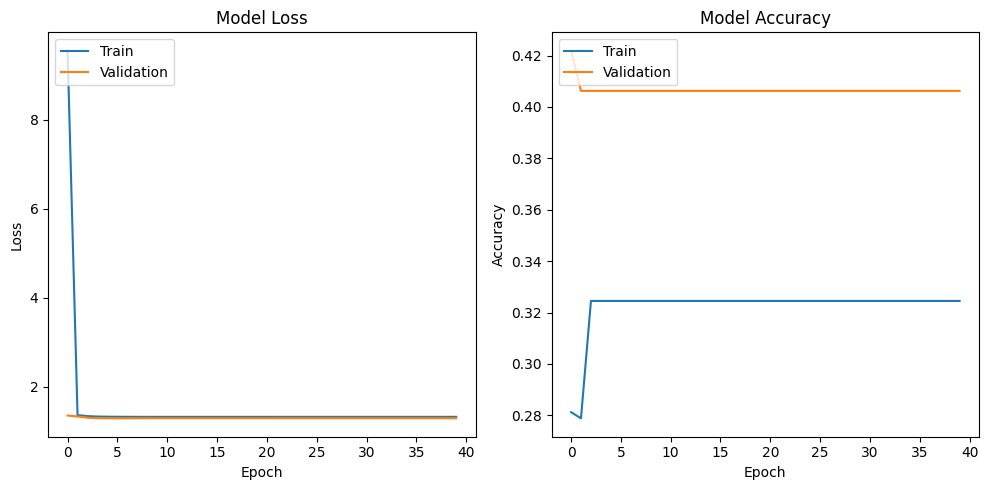

In [ ]:
with strategy.scope():
    model = build_from_scratch_model()
model.summary()
epochs = 40  # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 4)                 4054695   
 )                                                               
                                                                 
Total params: 4054695 (15.47 MB)
Trainable params: 4012672 (15.31 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________
Epoch 1/40
13/13 - 45s - loss: 3.1609 - accuracy: 0.4471 - val_loss: 1.3223 - val_accuracy: 0.4062 - 45s/epoch - 3s/step
Epoch 2/40
13/13 - 5s - loss: 1.8827 - accuracy: 0.5072 - val_loss: 1.6158 - val_accuracy: 0.4062 - 5s/epoch - 349ms/step
Epoch 3/40
13/13 - 4s - loss: 1.6252 - accuracy: 0.5385 - val_loss: 2.6497 - val_accuracy: 0.4062 - 4s/e

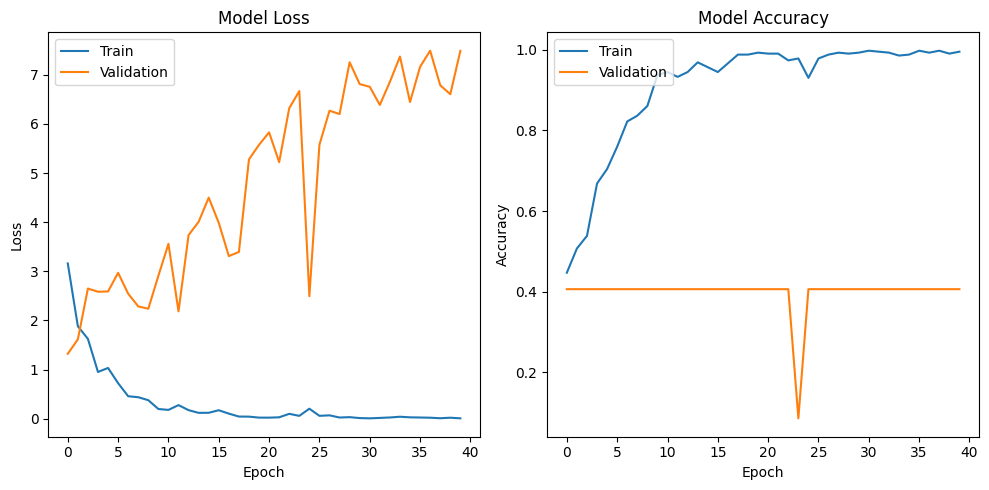

In [ ]:
with strategy.scope():
    model = build_model_non_pretrained_weights()
model.summary()
epochs = 40  # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/40
13/13 - 10s - loss: 130.6928 - accuracy: 0.2933 - val_loss: 109.2433 - val_accuracy: 0.4062 - 10s/epoch - 763ms/step
Epoch 2/40
13/13 - 1s - loss: 107.5347 - accuracy: 0.2620 - val_loss: 111.4603 - val_accuracy: 0.2812 - 1s/epoch - 107ms/step
Epoch 3/40
13/13 - 1s - loss: 72.1746 - accuracy: 0.2668 - val_loss: 41.8356 - val_accuracy: 0.4062 - 1s/epoch - 104ms/step
Epoch 4/40
13/13 - 1s - loss: 43.9771 - accuracy: 0.2788 - val_loss: 53.8876 - val_accuracy: 0.4062 - 1s/epoch - 105ms/step
Epoch 5/40
13/13 - 1s - loss: 32.7029 - accuracy: 0.3029 - val_loss: 31.0013 - val_accuracy: 0.2266 - 1s/epoch - 105ms/step
Epoch 6/40
13/13 - 1s - loss: 31.0076 - accuracy: 0.2740 - val_loss: 56.8884 - val_accuracy: 0.4062 - 1s/epoch - 113ms/step
Epoch 7/40
13/13 - 1s - loss: 45.9818 - accuracy: 0.2500 - val_loss: 36.6694 - val_accuracy: 0.4062 - 1s/epoch - 105ms/step
Epoch 8/40
13/13 - 1s - loss: 49.4532 - accuracy: 0.2740 - va

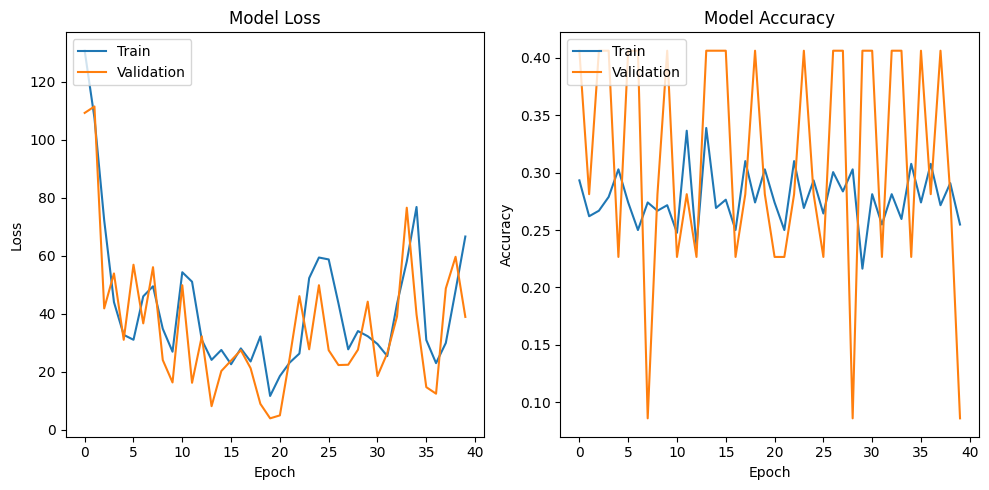

In [ ]:
with strategy.scope():
    model = build_model_with_pretrained_weights_efficientNet()
# model.summary()
epochs = 40  # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/40
13/13 - 12s - loss: 1.0277 - accuracy: 0.5577 - val_loss: 1.6048 - val_accuracy: 0.3281 - 12s/epoch - 933ms/step
Epoch 2/40
13/13 - 3s - loss: 0.5677 - accuracy: 0.7764 - val_loss: 1.7995 - val_accuracy: 0.2266 - 3s/epoch - 223ms/step
Epoch 3/40
13/13 - 3s - loss: 0.4046 - accuracy: 0.8413 - val_loss: 1.7012 - val_accuracy: 0.2266 - 3s/epoch - 216ms/step
Epoch 4/40
13/13 - 3s - loss: 0.3148 - accuracy: 0.8846 - val_loss: 1.6453 - val_accuracy: 0.2891 - 3s/epoch - 216ms/step
Epoch 5/40
13/13 - 3s - loss: 0.3233 - accuracy: 0.8630 - val_loss: 1.6038 - val_accuracy: 0.2266 - 3s/epoch - 217ms/step
Epoch 6/40
13/13 - 4s - loss: 0.2715 - accuracy: 0.9014 - val_loss: 1.4714 - val_accuracy: 0.2500 - 4s/epoch - 277ms/step
Epoch 7/40
13/13 - 3s - loss: 0.2784 - accuracy: 0.8894 - val_loss: 1.3922 - val_accuracy: 0.3047 - 3s/epoch - 221ms/step
Epoch 8/40
13/13 - 3s - loss: 0.2660 - accuracy: 0.8894 - val_loss: 1.3557 - va

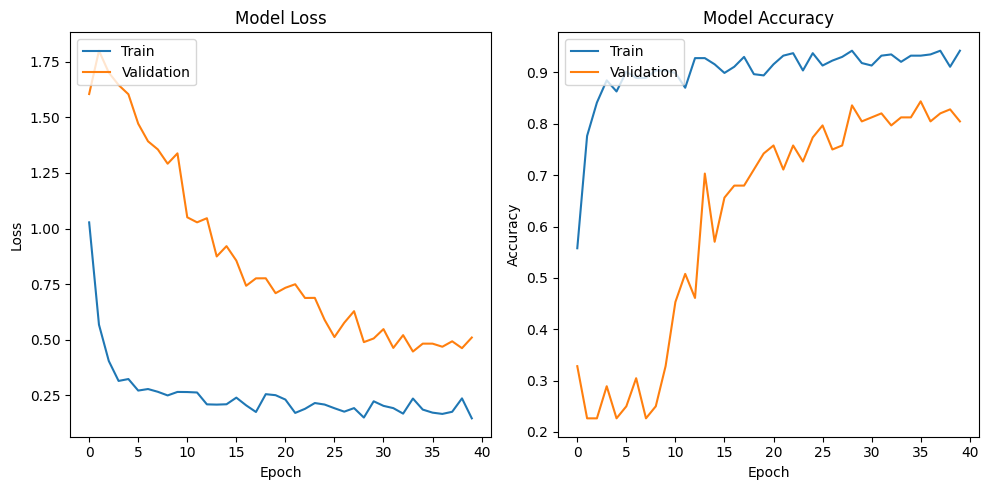

In [ ]:
with strategy.scope():
    model = build_model_with_pretrained_weights_vgg16()
#model.summary()
epochs = 40  # @param {type: "slider", min:10, max:100}
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    monitor="val_loss"
)
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2, callbacks=[early_stopping])
plot_hist(hist)

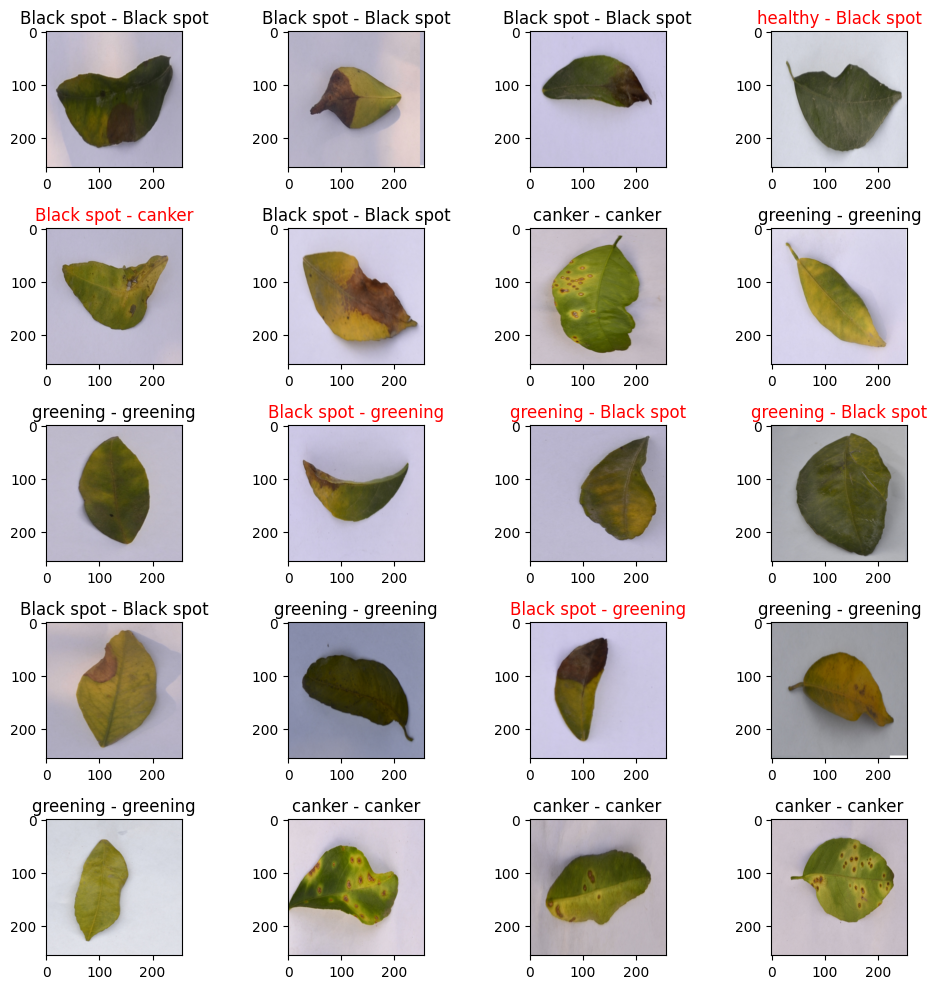

In [ ]:
batch = ds_test.take(1)  # Get a single batch of data
images = batch.unbatch().take(20)  # Extract 20 images from the batch

fig = plt.figure(figsize=(10, 10))  # Create a figure for visualization
num_cols = 4  # Number of images per row in the plot
num_rows = math.ceil(len(images) / num_cols)  # Number of rows needed to display all images

for i, (img, img_label) in enumerate(images.as_numpy_iterator()):
  """
  Loop through each image and its corresponding label.
  """

  # Add a dimension to the image tensor for model prediction (single image)
  img = np.expand_dims(img, axis=0)

  # Make prediction using the model
  predictions = model(img)

  # Remove the extra dimension after prediction (squeeze)
  predictions = np.squeeze(predictions)

  # Get the predicted label index
  predicted_label = np.argmax(predictions)

  # Convert the predicted label index to human-readable label using labels list
  predicted_label = labels[predicted_label]

  # Get the true label index from the one-hot encoded label
  img_label = np.argmax(img_label, axis=0)
  # Convert the true label index to human-readable label using labels list
  img_label = labels[img_label]

  # Create a subplot for each image and its prediction
  ax = fig.add_subplot(num_rows, num_cols, i + 1)
  ax.imshow(img[0, ...])  # Display the image

  # Set the subplot title with true label and predicted label
  # - Use red color for incorrect predictions and black for correct ones
  c = "red" if predicted_label != img_label else "black"
  ax.set_title(f"{img_label} - {predicted_label}", color=c)

# Adjust spacing for better readability
plt.tight_layout()

# Display the created figure
plt.show()


# What next ?

- Generate validation metrics such as the confusion matrix
- Try out some explainable ai tecniques for CNN
- Test how is the performance of the model using transformers
- Export the model to tflite/tfjs and import it into a web or mobile application
- Provide some information to the user about the disease